# Scenario 1: Calibrating models and estimating causal effects

In this scenario, we are interested in determining the effects of masking and social distancing on Covid-19 infections using simulated data for four different countries: Afghanistan, Colombia, France, and the United Kingdom. The simulations use contact matrices and populations subdivided into age groups for each of the countries. In these simulations, each country implements interventions at the same time, and we are interested in understanding how the effects of the interventions differ between countries. The data are generated from an SEIRD model. 

In these questions, we provide the contact matrices and population data for each country, as well as the outputs of the simulated SEIRD model. We ask you to calibrate a model to estimate R0, and to estimate the causal effects of interventions.

In the data provided, ‘UK_population.csv’ and ‘UK_contact_matrix.csv’ contain data on the population counts and the contact matrix for each age group in the UK. ‘UK_compartments.csv’ has compartments S, E, ICase, IMild, R, and D. All patients in IMild transition to R, whereas all patients in ICase transition to the hospital (IHospital, not currently included in this output). From there, some patients recover and others transition to D. ‘UK_infections.csv’ has total infections for each day. There are analogous files for the other countries.

In each country:
1. From t = 0 to t = 40 days, there are no interventions in place, and Covid spreads unabated.
2. At t = 40 days, people begin wearing masks, decreasing the spread of covid.
3. At t = 100 days, mask fatigue sets in. People start to mask less, but more than they did from t = 0 to t = 40. Cases increase again.

During this same time frame, each country begins implementing a social distancing policy at t = 60 days. Due to the policy, contact decreases to 30% of its original levels for the interactions of people over the age of 65 with others over the age of 65 (i.e., the 3x3 matrix on the bottom right of the contact matrix) and it decreases to 60% of its original levels otherwise.

Because this model is stochastic, (in particular, the number of people transitioning between compartments is randomly drawn from a binomial distribution), we run each simulation ten times for each country. The dt parameter is set to 0.2 so that there are 5 time steps per day and 1000 time steps in each 200-day simulation.

Using the data provided, which includes contact matrices and population counts for all four countries, along with the output from running 10 simulations for each country:

### (1) Calibrate models to estimate R0 for each country in each of the four time intervals: [0,40), [40,60), [60,100), [100, 200].

### (2) Estimate the causal effects of masking alone, the combined effect of masking and social distancing, and the effect of social distancing alone on infections. Include uncertainty in the estimated effects.

### (3) (Optional) In each country, what is the maximum value R0  can be over the last time interval ([100, 200]), to ensure that there are no more than 50 infections at t = 200 days with 90% confidence? Are these different across countries? 

### (4) (Optional) Can R0 be changed in one of the three preceding intervals ([0,40), [40,60), [60,100)), without changing it in the fourth, to ensure that infections at t = 200 days stay below ¾ of their simulated value at t = 200 with 95% confidence?"

### Load dependencies, PyCIEMSS tools

In [1]:
import os
import pyciemss
import torch
import pandas as pd
import numpy as np
import requests
from io import StringIO
from typing import Dict, List

import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

# Country 1: Let's start with France

## Collect data

In [2]:
DATA_PATH = "https://raw.githubusercontent.com/ciemss/program-milestones/epi-scenario-1/18-month-milestone/hackathon/epi/Scenario%201%20Supplemental/"

COUNTRY = "France" # "UK", "Afghanistan", "Colombia"
infection_data = os.path.join(DATA_PATH, COUNTRY + "_infections.csv")
death_data = os.path.join(DATA_PATH, COUNTRY + "_compartments.csv")
population_data = os.path.join(DATA_PATH, COUNTRY + "_population.csv")
contact_matrix = os.path.join(DATA_PATH, COUNTRY + "_contact_matrix.csv")

### Define functions to read and manipulate data

In [3]:
def read_data(data_location: str):
    
    # Fetch the contents of the CSV file from the URL
    response = requests.get(data_location)
    csv_content = StringIO(response.text)
    df = pd.read_csv(csv_content)
    # print(df.head())
    
    return df

def add_over_age_groups(df: pd.DataFrame, input_comp: str, output_comp: str):

    # Aggregate data by age
    df = df.drop(columns=['Unnamed: 0'])
    replicate_1_df = df[df['replicate'] == 1] # only using first run
    compartment_df = replicate_1_df[replicate_1_df["compartment"] == input_comp] # only use chosen compartment
    result = compartment_df.groupby('t')['y'].sum().reset_index()
    result.rename(columns={'t': 'Timestamp', 'y': output_comp}, inplace=True)
    result.set_index('Timestamp', inplace=True)
    result.index.name = 'Timestamp'
    # print(result.head())

    return result

### Produce dataset for calibration, calculate total population

In [4]:
# Aggregate case data by age
case_by_age_df = read_data(infection_data)
data_df = add_over_age_groups(case_by_age_df, "infections", "cases")

# # Aggregate death data by age
# death_by_age_df = read_data(death_data)
# death_df = add_over_age_groups(death_by_age_df, "D", "deaths")

# # # Merge data into one DataFrame
# death_column = death_df["deaths"]
# data_df = pd.concat([data_df, death_column], axis=1)

# data_df.to_csv(COUNTRY + "_case_death_data.csv", index=True)
data_df.to_csv(COUNTRY + "_case_data.csv", index=True)

# Calculate the total population
pop_data_by_age = read_data(population_data)
total_population = pop_data_by_age["n"].sum()
print(COUNTRY + " total population:", total_population)

France total population: 65273512


### Divide data for calibration into interval datasets (might not need these after all!)

In [5]:
def truncate_original_data(begin_time:int, cutoff_time: int):
    
    # Read the original CSV file
    original_data = pd.read_csv(COUNTRY + "_case_data.csv")

    # Filter rows to keep only integer values in the 'Timestamp' column
    original_data = original_data[original_data['Timestamp'].astype(int) == original_data['Timestamp']]

    # Filter rows based on Timestamp ranges
    return original_data[(original_data['Timestamp'] >= begin_time) & (original_data['Timestamp'] <= cutoff_time)]

# Save truncated data to new CSV files
truncate_original_data(0, 39).to_csv(COUNTRY + "_data1.csv", index=False)
truncate_original_data(0, 59).to_csv(COUNTRY + "_data2.csv", index=False)
truncate_original_data(0, 99).to_csv(COUNTRY + "_data3.csv", index=False)
truncate_original_data(0, 200).to_csv(COUNTRY + "_data4.csv", index=False)

## Create base model
This code is adapted from https://github.com/gyorilab/mira/blob/main/notebooks/hackathon_2024.02/scenario1/epi_scenario1.ipynb

### Load mira dependencies

In [ ]:
# General imports
import sympy
import json
from mira.metamodel import *
from mira.examples.concepts import susceptible, exposed, infected, recovered, dead
from mira.modeling import Model
from mira.modeling.amr.petrinet import AMRPetriNetModel, template_model_to_petrinet_json
from mira.metamodel.io import model_to_json_file, model_from_json_file
from pathlib import Path

In [ ]:
# Build base model
person_units = lambda: Unit(expression=sympy.Symbol('person'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))
per_day_per_person_units = lambda: Unit(expression=1/(sympy.Symbol('day')*sympy.Symbol('person')))

_infected = Concept(name='I', units=person_units(), identifiers={'ido': '0000511'})

c = {
    'S': Concept(name='S', units=person_units(), identifiers={'ido': '0000514'}),
    'E': Concept(name='E', units=person_units(), identifiers={'apollosv': '00000154'}),
    'I_mild': _infected.with_context(status="mild"),
    'I_case': _infected.with_context(status="case"),
    'R': Concept(name='R', units=person_units(), identifiers={'ido': '0000592'}),
    'I_hosp': _infected.with_context(status="hosp"),
    'D': Concept(name='D', units=person_units(), identifiers={'ncit': 'C28554'}),
}
c['I_case'].name = 'I_case'
c['I_mild'].name = 'I_mild'
c['I_hosp'].name = 'I_hosp'


parameters = {
    'beta_mild': Parameter(name='beta_mild', units=per_day_units()),  # Infection rate from I_mild
    'beta_case': Parameter(name='beta_case', units=per_day_units()),  # Infection rate from I_case
    'alpha_mild': Parameter(name='alpha_mild', units=per_day_units()),  # Rate of progressing E -> I_mild
    'alpha_case': Parameter(name='alpha_case', units=per_day_units()),  # Rate of progressing E -> I_case
    'gamma_mildR': Parameter(name='gamma_mildR', units=per_day_units()),  # Rate of progressing I_mild -> R
    'gamma_caseH': Parameter(name='gamma_caseH', units=per_day_units()),  # Rate of progressing I_case -> I_hosp
    'delta_caseR': Parameter(name='delta_caseR', units=per_day_units()),  # Rate of progressing I_hosp -> R
    'mu_caseD': Parameter(name='mu_caseD', units=per_day_units()),  # Rate of progressing I_hosp -> D
    'N': Parameter(name='N', value=total_population, units=person_units()), 
}

S, E, I_mild, I_case, I_hosp, R, D, N, t_0, t, beta_mild, beta_case, alpha_mild, alpha_case, gamma_mildR, gamma_caseH, delta_caseR, mu_caseD = \
    sympy.symbols(
        'S E I_mild I_case I_hosp R D N t_0 t beta_mild beta_case alpha_mild alpha_case gamma_mildR gamma_caseH delta_caseR mu_caseD'
    )


# S -> E by I_mild
exposure_mild = ControlledConversion(
    subject=c['S'],
    outcome=c['E'],
    controller=c['I_mild'],
    rate_law=S*I_mild*beta_mild / N
)
# S -> E by I_case
exposure_case = ControlledConversion(
    subject=c['S'],
    outcome=c['E'],
    controller=c['I_case'],
    rate_law=S*I_case*beta_case / N
)

# E -> I_mild
infection_mild = NaturalConversion(
    subject=c['E'],
    outcome=c['I_mild'],
    rate_law=alpha_mild*E
)
# E -> I_case
infection_case = NaturalConversion(
    subject=c['E'],
    outcome=c['I_case'],
    rate_law=alpha_case*E
)

# I_mild -> R
recovery_mild = NaturalConversion(
    subject=c['I_mild'],
    outcome=c['R'],
    rate_law=gamma_mildR*I_mild
)
# I_case -> I_hosp
hospitalized_case = NaturalConversion(
    subject=c['I_case'],
    outcome=c['I_hosp'],
    rate_law=gamma_caseH*I_case
)
# I_hosp -> R
recovery_case = NaturalConversion(
    subject=c['I_hosp'],
    outcome=c['R'],
    rate_law=delta_caseR*I_hosp
)
# I_hosp -> D
death_case = NaturalConversion(
    subject=c['I_hosp'],
    outcome=c['D'],
    rate_law=mu_caseD*I_hosp
)

seiirhd_model = TemplateModel(
    templates=[
        exposure_mild,
        exposure_case,
        infection_mild,
        infection_case,
        recovery_mild,
        hospitalized_case,
        recovery_case,
        death_case,
    ],
    parameters=parameters,
    time=Time(name='t', units=day_units()),
    annotations=Annotations(name='EPI Scenario 1 France')
)

# Save as JSON
with open("SEIIRHD_model_" + COUNTRY + ".json', 'w') as fh:
    json.dump(template_model_to_petrinet_json(seiirhd_model), fh, indent=1)

## Simulate model

### Set model path

In [7]:
COUNTRY = "France"
local = True

if local:
    model = "SEIIRHD_model_France.json"
else:
    # From url
    MODEL_PATH = "https://raw.githubusercontent.com/ciemss/program-milestones/epi-scenario-1/18-month-milestone/hackathon/epi/scenario1/ciemss/"
    model = os.path.join(MODEL_PATH, "SEIIRHD_model_" + COUNTRY + ".json")

### Set simulation parameters

In [8]:
start_time = 0.0
end_time = 200.0
logging_step_size = 1.0
num_samples = 100

### Simulate the model and plot the results

In [ ]:
result1 = pyciemss.sample(model, end_time, logging_step_size, num_samples, start_time=start_time)
display(result1['data'].head())

# Plot results for all states
schema = plots.trajectories(result1["data"], keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Calibrate the model for each time interval

### Calibrate the model to case data for $t$ in [0, 40) 

In [9]:
dataset = COUNTRY + "_data1.csv"
data_mapping = {"cases": "infected"} 

num_iterations = 200
calibrated_results = pyciemss.calibrate(model, dataset, data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
parameter_estimates()

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 38 rows of data. The first column, Timestamp, begins at 1.0 and ends at 39.0. The subsequent columns are named: cases


{'persistent_beta_mild': tensor(0.3300, grad_fn=<ExpandBackward0>),
 'persistent_beta_case': tensor(0.3818, grad_fn=<ExpandBackward0>),
 'persistent_gamma_mildR': tensor(0.1411, grad_fn=<ExpandBackward0>),
 'persistent_gamma_caseH': tensor(0.1341, grad_fn=<ExpandBackward0>),
 'persistent_delta_caseR': tensor(0.2478, grad_fn=<ExpandBackward0>),
 'persistent_mu_caseD': tensor(0.0212, grad_fn=<ExpandBackward0>),
 'persistent_Im0': tensor(1.2163, grad_fn=<ExpandBackward0>),
 'persistent_Ic0': tensor(1.5458, grad_fn=<ExpandBackward0>)}

### Plot calibrated results

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_mild_param,persistent_beta_case_param,persistent_gamma_mildR_param,persistent_gamma_caseH_param,persistent_delta_caseR_param,persistent_mu_caseD_param,persistent_Im0_param,persistent_Ic0_param,D_state,E_state,I_case_state,I_hosp_state,I_mild_state,R_state,S_state,infected_observable_state
0,0,0,1.0,0.336421,0.382544,0.141728,0.138634,0.209772,0.025129,1.212543,1.524547,0.002383,0.730500,1.442337,0.180747,1.148171,0.184938,65273512.0,2.771255
1,1,0,2.0,0.336421,0.382544,0.141728,0.138634,0.209772,0.025129,1.212543,1.524547,0.008787,1.161922,1.526230,0.325303,1.221640,0.405195,65273512.0,3.073173
2,2,0,3.0,0.336421,0.382544,0.141728,0.138634,0.209772,0.025129,1.212543,1.524547,0.018620,1.481699,1.701319,0.456282,1.370314,0.670269,65273512.0,3.527914
3,3,0,4.0,0.336421,0.382544,0.141728,0.138634,0.209772,0.025129,1.212543,1.524547,0.031706,1.773915,1.938085,0.585603,1.569521,0.987305,65273512.0,4.093209
4,4,0,5.0,0.336421,0.382544,0.141728,0.138634,0.209772,0.025129,1.212543,1.524547,0.048098,2.078299,2.227167,0.720498,1.811437,1.363245,65273512.0,4.759101


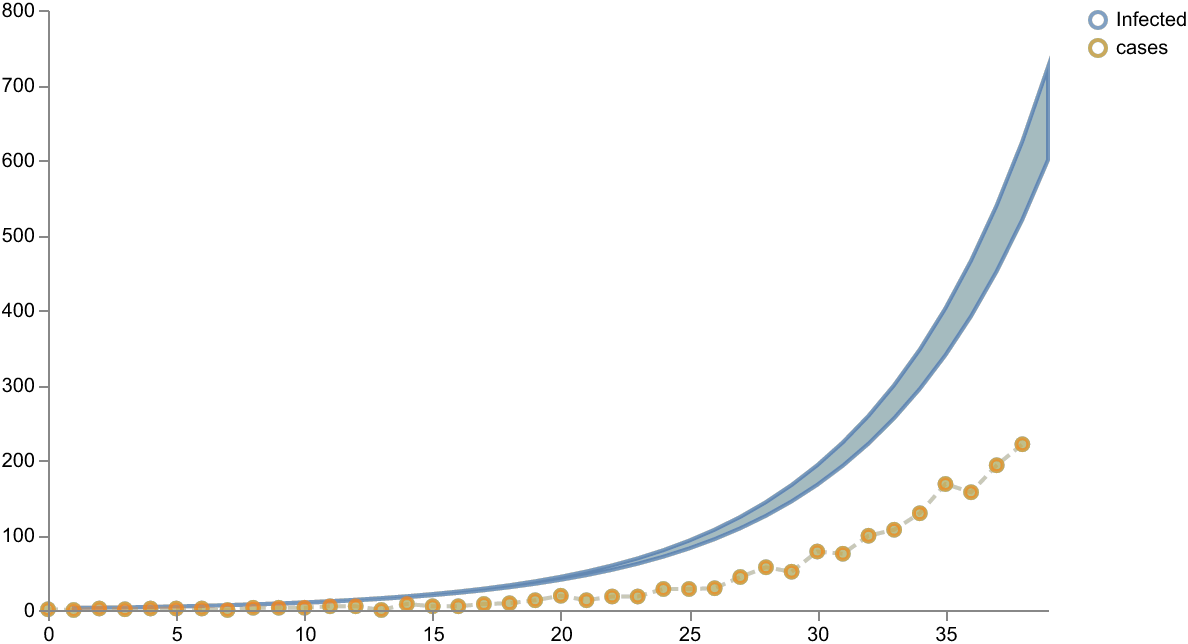

In [10]:
start_time = 0.0
end_time = 40.0
calibrated_sample_results = pyciemss.sample(model, end_time, logging_step_size, num_samples, 
                start_time=start_time, inferred_parameters=parameter_estimates)
display(calibrated_sample_results["data"].head())

# Plot the result
nice_labels = {
        "infected_observable_state": "Infected",
        }
nice_data_names = {
        "case": "Case Data"
        }
data_df = pd.read_csv(dataset)
data_df.rename(columns=nice_data_names, inplace=True)
# data_df.drop(columns=['Timestamp'], inplace=True)
schema = plots.trajectories(pd.DataFrame(calibrated_sample_results["data"]), 
                           keep=["infected_observable_state"], 
                           relabel=nice_labels,
                           points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
                           )

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Calibrate the model to case data for $t$ in [40, 60) 

### Declare intervention on transmission rates at `t = 40`

In [26]:
static_intervention40A = {torch.tensor(40.0): {"beta_mild": lambda x : x/2, "beta_case": lambda x : x/2}}
static_intervention40B = {torch.tensor(40.0): {"beta_mild": lambda x : x/2, 
                                               "beta_case": lambda x : x/2, 
                                               "gamma_mildR": lambda x : x/2,
                                               "gamma_caseH": lambda x : x/2
                                              }}

# Try with distributions
import pyro
import pyro.distributions as dist
mask_effect = pyro.sample("mask_effect", dist.Uniform(0,1))
static_intervention40C = {torch.tensor(40.0): {"beta_mild": lambda x: x*mask_effect, 
                                               "beta_case": lambda x: x*mask_effect
                                              }}

### Calibrate the intervened model to data from `t = 0` to `t = 60`

In [31]:
dataset = COUNTRY + "_data2.csv"
num_iterations = 500
calibrated_results = pyciemss.calibrate(model, dataset, data_mapping=data_mapping, 
                                        static_parameter_interventions=static_intervention40A,
                                        num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
parameter_estimates()

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 58 rows of data. The first column, Timestamp, begins at 1.0 and ends at 59.0. The subsequent columns are named: cases


{'persistent_beta_mild': tensor(0.2822, grad_fn=<ExpandBackward0>),
 'persistent_beta_case': tensor(0.4059, grad_fn=<ExpandBackward0>),
 'persistent_gamma_mildR': tensor(0.1473, grad_fn=<ExpandBackward0>),
 'persistent_gamma_caseH': tensor(0.1438, grad_fn=<ExpandBackward0>),
 'persistent_delta_caseR': tensor(0.2489, grad_fn=<ExpandBackward0>),
 'persistent_mu_caseD': tensor(0.0278, grad_fn=<ExpandBackward0>),
 'persistent_Im0': tensor(1.5958, grad_fn=<ExpandBackward0>),
 'persistent_Ic0': tensor(1.5300, grad_fn=<ExpandBackward0>)}

### Plot calibrated results for the intervened model

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_mild_param,persistent_beta_case_param,persistent_gamma_mildR_param,persistent_gamma_caseH_param,persistent_delta_caseR_param,persistent_mu_caseD_param,persistent_Im0_param,persistent_Ic0_param,D_state,E_state,I_case_state,I_hosp_state,I_mild_state,R_state,S_state,infected_observable_state
0,0,0,0.0,0.278428,0.403748,0.146143,0.142694,0.241654,0.028344,1.527243,1.525167,0.002735,0.764526,1.442872,0.182874,1.419906,0.236173,65273512.0,3.045653
1,1,0,1.0,0.278428,0.403748,0.146143,0.142694,0.241654,0.028344,1.527243,1.525167,0.009987,1.208455,1.532780,0.324674,1.461301,0.507272,65273512.0,3.318755
2,2,0,2.0,0.278428,0.403748,0.146143,0.142694,0.241654,0.028344,1.527243,1.525167,0.020994,1.528271,1.714149,0.450655,1.583094,0.822821,65273512.0,3.747899
3,3,0,3.0,0.278428,0.403748,0.146143,0.142694,0.241654,0.028344,1.527243,1.525167,0.035507,1.812061,1.954323,0.573546,1.757314,1.190085,65273512.0,4.285183
4,4,0,4.0,0.278428,0.403748,0.146143,0.142694,0.241654,0.028344,1.527243,1.525167,0.053547,2.100900,2.241971,0.700548,1.973909,1.616047,65273512.0,4.916428


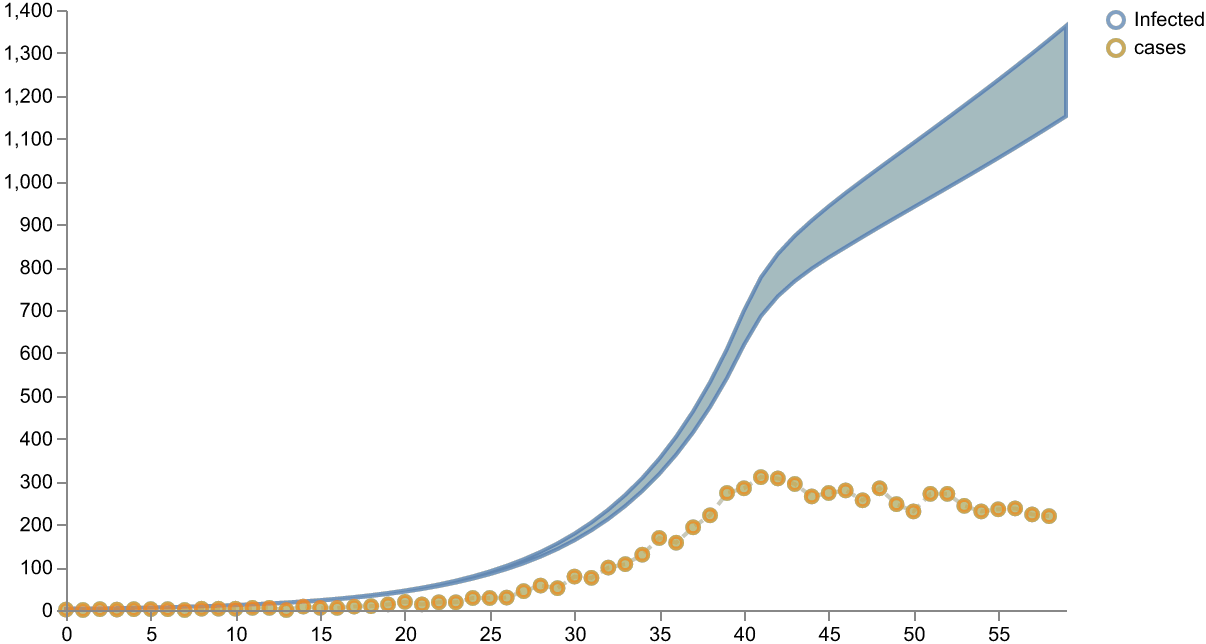

In [36]:
start_time = -1.0
end_time = 60.0
calibrated_sample_results = pyciemss.sample(model, end_time, logging_step_size, num_samples, 
                                            start_time=start_time, 
                                            inferred_parameters=parameter_estimates,
                                            static_parameter_interventions=static_intervention40A
                                           )
display(calibrated_sample_results["data"].head())

# Plot the result
nice_labels = {
        "infected_observable_state": "Infected",
        }
nice_data_names = {
        "case": "Case Data"
        }
data_df = pd.read_csv(dataset)
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(pd.DataFrame(calibrated_sample_results["data"]), 
                           keep=["infected_observable_state"], 
                           relabel=nice_labels,
                           points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
                           )

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Declare interventions on transmission rates at `t = 40`, `t = 60`, and `t = 100`

In [37]:
static_interventions4060 = {torch.tensor(40.0): {"beta_mild": lambda x : x/2, "beta_case": lambda x : x/2},
                            torch.tensor(60.0): {"beta_mild": lambda x : x/2, "beta_case": lambda x : x/2}}

static_interventions_all = {torch.tensor(40.0): {"beta_mild": lambda x : x/2, "beta_case": lambda x : x/2},
                            torch.tensor(60.0): {"beta_mild": lambda x : x/2, "beta_case": lambda x : x/2},
                            torch.tensor(100.0): {"beta_mild": lambda x : x/2, "beta_case": lambda x : x/2}}

### Calibrate the intervened model to data from `t = 0` to `t = 100`

In [38]:
dataset = COUNTRY + "_data3.csv"
num_iterations = 500
calibrated_results = pyciemss.calibrate(model, dataset, data_mapping=data_mapping, 
                                        static_parameter_interventions=static_interventions4060,
                                        num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
parameter_estimates()

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 98 rows of data. The first column, Timestamp, begins at 1.0 and ends at 99.0. The subsequent columns are named: cases


{'persistent_beta_mild': tensor(0.2211, grad_fn=<ExpandBackward0>),
 'persistent_beta_case': tensor(0.3766, grad_fn=<ExpandBackward0>),
 'persistent_gamma_mildR': tensor(0.1572, grad_fn=<ExpandBackward0>),
 'persistent_gamma_caseH': tensor(0.1494, grad_fn=<ExpandBackward0>),
 'persistent_delta_caseR': tensor(0.2441, grad_fn=<ExpandBackward0>),
 'persistent_mu_caseD': tensor(0.0278, grad_fn=<ExpandBackward0>),
 'persistent_Im0': tensor(1.9061, grad_fn=<ExpandBackward0>),
 'persistent_Ic0': tensor(2.1712, grad_fn=<ExpandBackward0>)}

### Plot calibrated results for the intervened model

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_mild_param,persistent_beta_case_param,persistent_gamma_mildR_param,persistent_gamma_caseH_param,persistent_delta_caseR_param,persistent_mu_caseD_param,persistent_Im0_param,persistent_Ic0_param,D_state,E_state,I_case_state,I_hosp_state,I_mild_state,R_state,S_state,infected_observable_state
0,0,0,0.0,0.21936,0.376156,0.156415,0.149421,0.239113,0.028986,1.888126,2.133793,0.004080,0.886619,1.977554,0.265860,1.731054,0.313524,65273508.0,3.974468
1,1,0,1.0,0.21936,0.376156,0.156415,0.149421,0.239113,0.028986,1.888126,2.133793,0.014773,1.380140,2.026331,0.464353,1.748925,0.672337,65273508.0,4.239609
2,2,0,2.0,0.21936,0.376156,0.156415,0.149421,0.239113,0.028986,1.888126,2.133793,0.030691,1.708892,2.178911,0.630364,1.856023,1.084735,65273508.0,4.665298
3,3,0,3.0,0.21936,0.376156,0.156415,0.149421,0.239113,0.028986,1.888126,2.133793,0.051177,1.976021,2.391575,0.781741,2.015083,1.555943,65273508.0,5.188399
4,4,0,4.0,0.21936,0.376156,0.156415,0.149421,0.239113,0.028986,1.888126,2.133793,0.075965,2.228896,2.646393,0.928391,2.210640,2.090485,65273508.0,5.785424


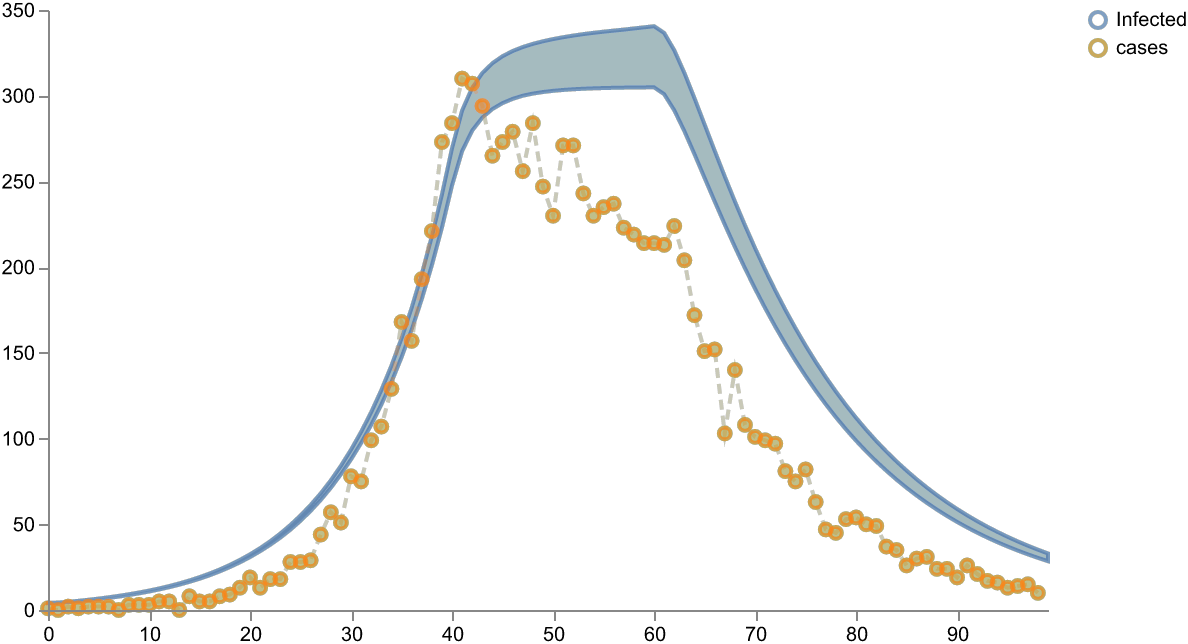

In [39]:
start_time = -1.0
end_time = 100.0
calibrated_sample_results = pyciemss.sample(model, end_time, logging_step_size, num_samples, 
                                            start_time=start_time, 
                                            inferred_parameters=parameter_estimates,
                                            static_parameter_interventions=static_interventions4060
                                           )
display(calibrated_sample_results["data"].head())

# Plot the result
nice_labels = {
        "infected_observable_state": "Infected",
        }
nice_data_names = {
        "case": "Case Data"
        }
data_df = pd.read_csv(dataset)
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(pd.DataFrame(calibrated_sample_results["data"]), 
                           keep=["infected_observable_state"], 
                           relabel=nice_labels,
                           points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
                           )

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Calibrate the intervened model to data from `t = 0` to `t = 200`

In [21]:
dataset = COUNTRY + "_data4.csv"
num_iterations = 500
calibrated_results = pyciemss.calibrate(model, dataset, data_mapping=data_mapping, 
                                        static_parameter_interventions=static_interventions_all,
                                        num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
parameter_estimates()

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 199 rows of data. The first column, Timestamp, begins at 1.0 and ends at 200.0. The subsequent columns are named: cases


{'persistent_beta_mild': tensor(0.3283, grad_fn=<ExpandBackward0>),
 'persistent_beta_case': tensor(0.4412, grad_fn=<ExpandBackward0>),
 'persistent_gamma_mildR': tensor(0.1251, grad_fn=<ExpandBackward0>),
 'persistent_gamma_caseH': tensor(0.1299, grad_fn=<ExpandBackward0>),
 'persistent_delta_caseR': tensor(0.1777, grad_fn=<ExpandBackward0>),
 'persistent_mu_caseD': tensor(0.0245, grad_fn=<ExpandBackward0>),
 'persistent_Im0': tensor(2.7069, grad_fn=<ExpandBackward0>),
 'persistent_Ic0': tensor(2.9977, grad_fn=<ExpandBackward0>)}

### Plot calibrated results for the intervened model

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_mild_param,persistent_beta_case_param,persistent_gamma_mildR_param,persistent_gamma_caseH_param,persistent_delta_caseR_param,persistent_mu_caseD_param,persistent_Im0_param,persistent_Ic0_param,D_state,E_state,I_case_state,I_hosp_state,I_mild_state,R_state,S_state,infected_observable_state
0,0,0,1.0,0.328881,0.443646,0.123138,0.130531,0.178048,0.024261,2.848154,2.956328,0.004267,1.672618,2.857966,0.338353,2.738234,0.370875,65273504.0,5.934553
1,1,0,2.0,0.328881,0.443646,0.123138,0.130531,0.178048,0.024261,2.848154,2.956328,0.016039,2.700703,3.135007,0.628388,2.945031,0.804820,65273504.0,6.708426
2,2,0,3.0,0.328881,0.443646,0.123138,0.130531,0.178048,0.024261,2.848154,2.956328,0.034713,3.511098,3.629574,0.912232,3.338202,1.327144,65273504.0,7.880007
3,3,0,4.0,0.328881,0.443646,0.123138,0.130531,0.178048,0.024261,2.848154,2.956328,0.060438,4.297368,4.285058,1.212633,3.871017,1.958463,65273504.0,9.368708
4,4,0,5.0,0.328881,0.443646,0.123138,0.130531,0.178048,0.024261,2.848154,2.956328,0.093809,5.155210,5.090124,1.544590,4.534285,2.719500,65273504.0,11.168999


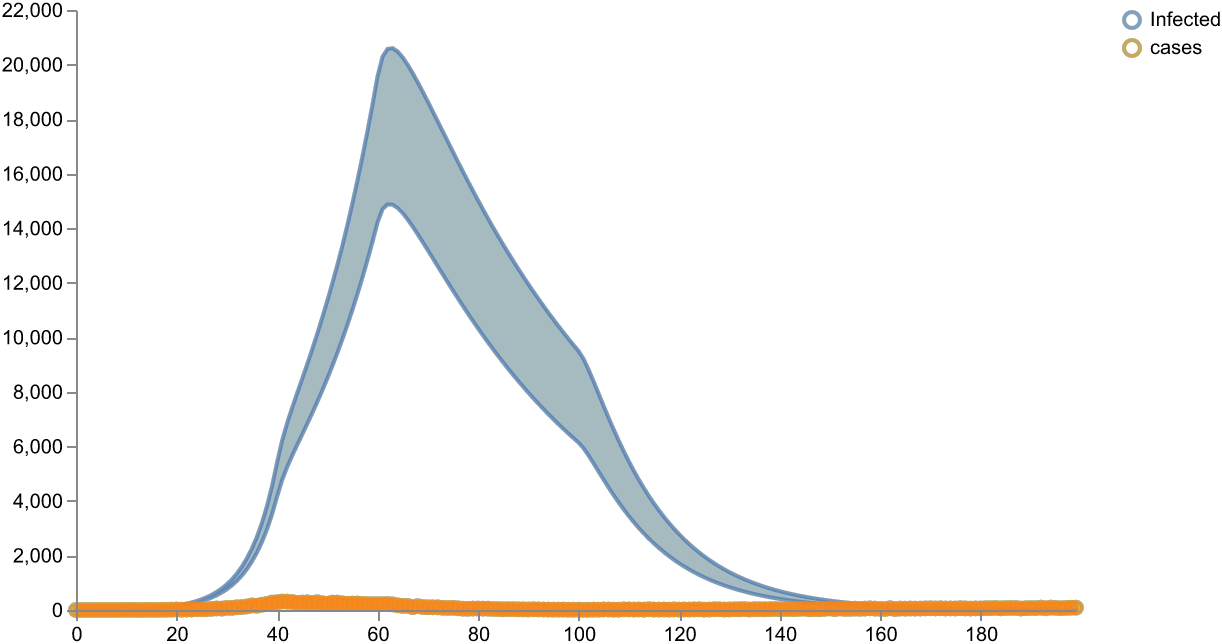

In [22]:
start_time = 0.0
end_time = 200.0
calibrated_sample_results = pyciemss.sample(model, end_time, logging_step_size, num_samples, 
                                            start_time=start_time, 
                                            inferred_parameters=parameter_estimates,
                                            static_parameter_interventions=static_interventions_all
                                           )
display(calibrated_sample_results["data"].head())

# Plot the result
nice_labels = {
        "infected_observable_state": "Infected",
        }
nice_data_names = {
        "case": "Case Data"
        }
data_df = pd.read_csv(dataset)
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(pd.DataFrame(calibrated_sample_results["data"]), 
                           keep=["infected_observable_state"], 
                           relabel=nice_labels,
                           points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
                           )

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Try sampling from `t = 0` to `t = 200` without recalibrating

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_mild_param,persistent_beta_case_param,persistent_gamma_mildR_param,persistent_gamma_caseH_param,persistent_delta_caseR_param,persistent_mu_caseD_param,persistent_Im0_param,persistent_Ic0_param,D_state,E_state,I_case_state,I_hosp_state,I_mild_state,R_state,S_state,infected_observable_state
0,0,0,1.0,0.257292,0.351892,0.159242,0.149496,0.248532,0.029306,2.6412,1.469499,0.002849,0.870765,1.402914,0.184356,2.366569,0.419446,65273508.0,3.953839
1,1,0,2.0,0.257292,0.351892,0.159242,0.149496,0.248532,0.029306,2.6412,1.469499,0.010435,1.354393,1.525415,0.329757,2.281443,0.852092,65273508.0,4.136615
2,2,0,3.0,0.257292,0.351892,0.159242,0.149496,0.248532,0.029306,2.6412,1.469499,0.022060,1.676549,1.739236,0.462774,2.298666,1.314324,65273508.0,4.500677
3,3,0,4.0,0.257292,0.351892,0.159242,0.149496,0.248532,0.029306,2.6412,1.469499,0.037555,1.938912,2.003064,0.595119,2.379450,1.817506,65273508.0,4.977633
4,4,0,5.0,0.257292,0.351892,0.159242,0.149496,0.248532,0.029306,2.6412,1.469499,0.056988,2.188082,2.300766,0.732206,2.506816,2.370808,65273508.0,5.539788


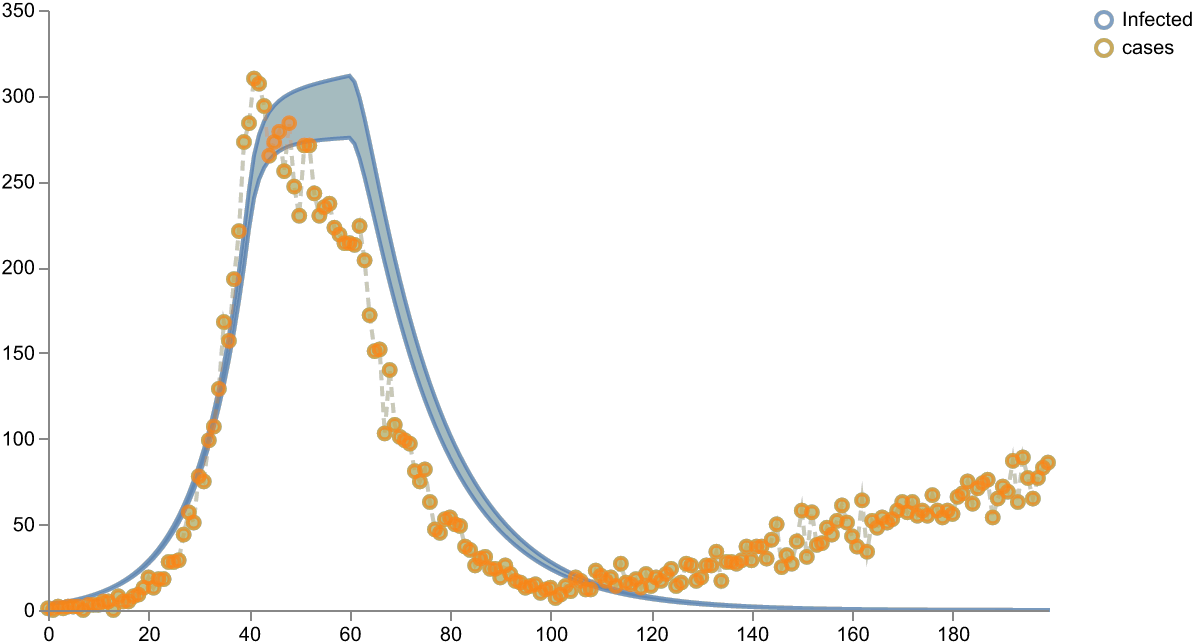

In [24]:
dataset = COUNTRY + "_data4.csv"
start_time = 0.0
end_time = 200.0
calibrated_sample_results = pyciemss.sample(model, end_time, logging_step_size, num_samples, 
                                            start_time=start_time, 
                                            inferred_parameters=parameter_estimates,
                                            static_parameter_interventions=static_interventions4060
                                           )
display(calibrated_sample_results["data"].head())

# Plot the result
nice_labels = {
        "infected_observable_state": "Infected",
        }
nice_data_names = {
        "case": "Case Data"
        }
data_df = pd.read_csv(dataset)
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(pd.DataFrame(calibrated_sample_results["data"]), 
                           keep=["infected_observable_state"], 
                           relabel=nice_labels,
                           points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
                           )

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Estimating causal effects of various interventions

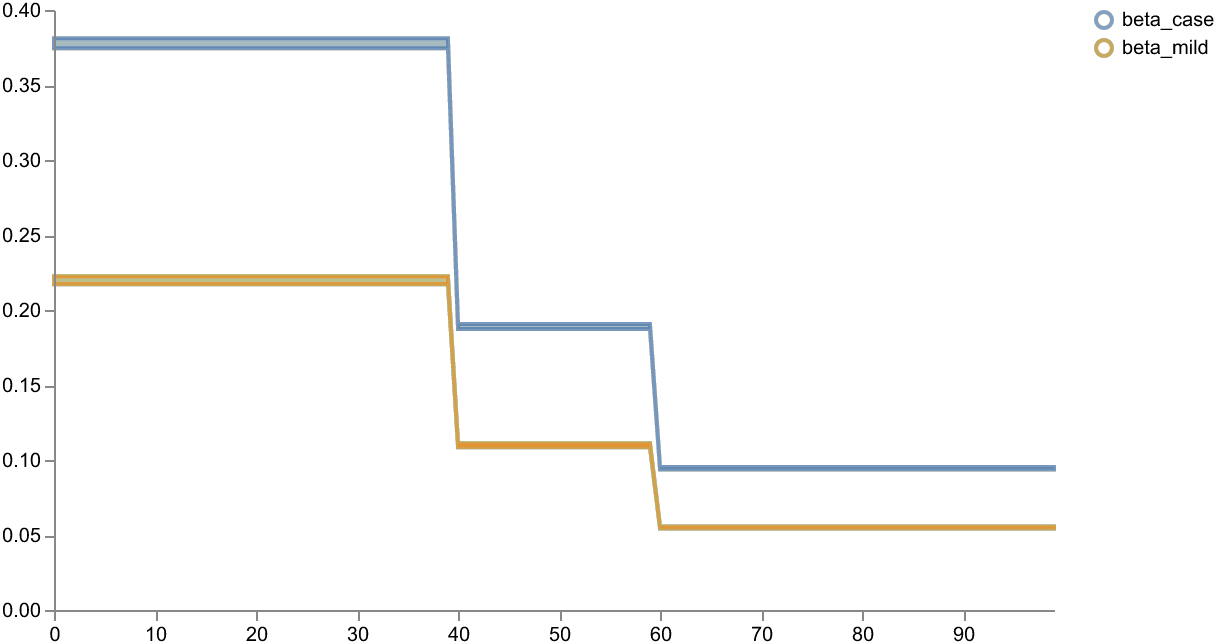

In [40]:
# Grab calibrated values from intervened model
calibrated_results_0_to_100 = calibrated_results
static_interventions = static_interventions4060

# Plot calibrated betas
nice_labels = {
        "persistent_beta_mild_param": "beta_mild",
        "persistent_beta_case_param": "beta_case"
        }
schema = plots.trajectories(pd.DataFrame(calibrated_sample_results["data"]), 
                           keep=["persistent_beta_mild_param", "persistent_beta_case_param"], 
                           relabel=nice_labels,
                           )

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 98 rows of data. The first column, Timestamp, begins at 1.0 and ends at 99.0. The subsequent columns are named: cases


,timepoint_id,sample_id,timepoint_unknown,persistent_beta_mild_param,persistent_beta_case_param,persistent_gamma_mildR_param,persistent_gamma_caseH_param,persistent_delta_caseR_param,persistent_mu_caseD_param,persistent_Im0_param,persistent_Ic0_param,D_state,E_state,I_case_state,I_hosp_state,I_mild_state,R_state,S_state,infected_observable_state
0,0,0,1.0,0.202461,0.388772,0.141975,0.137344,0.154101,0.022548,2.091494,1.819914,0.002576,0.829622,1.717521,0.219762,1.923791,0.299931,65273508.0,3.861074
1,1,0,2.0,0.202461,0.388772,0.141975,0.137344,0.154101,0.022548,2.091494,1.819914,0.009654,1.300967,1.802451,0.404566,1.923081,0.619999,65273508.0,4.130098
2,2,0,3.0,0.202461,0.388772,0.141975,0.137344,0.154101,0.022548,2.091494,1.819914,0.020730,1.623631,1.984118,0.577005,2.011943,0.974238,65273508.0,4.573066
3,3,0,4.0,0.202461,0.388772,0.141975,0.137344,0.154101,0.022548,2.091494,1.819914,0.035667,1.893023,2.223823,0.748401,2.156680,1.371696,65273508.0,5.128904
4,4,0,5.0,0.202461,0.388772,0.141975,0.137344,0.154101,0.022548,2.091494,1.819914,0.054520,2.153527,2.506312,0.925082,2.343408,1.819537,65273508.0,5.774803


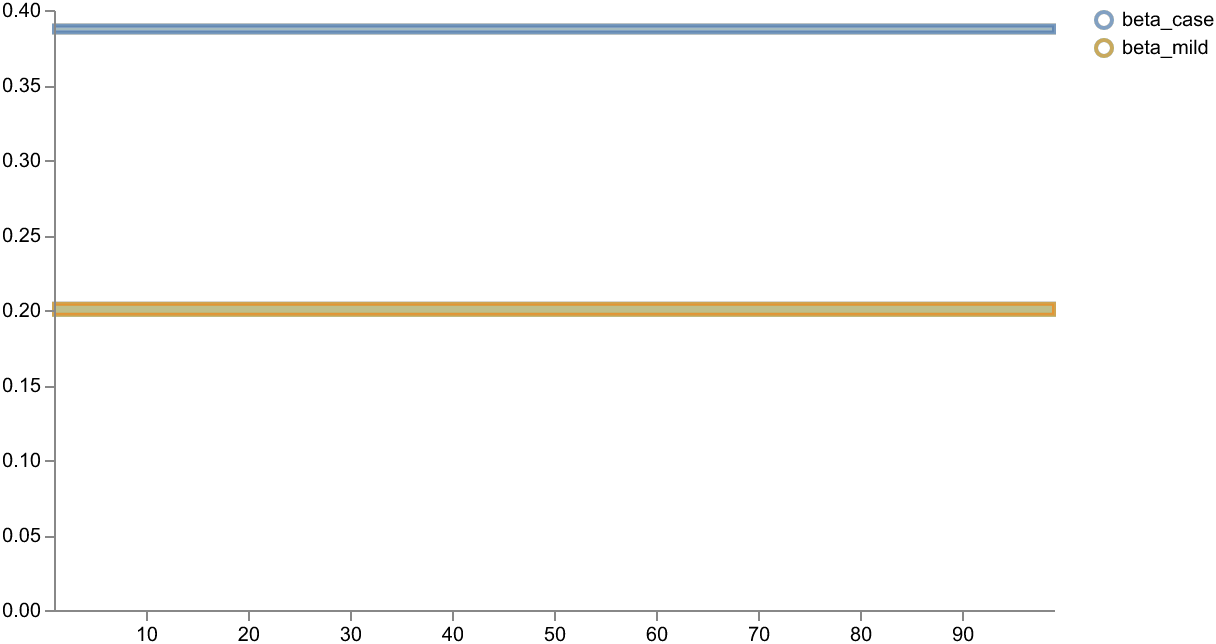

In [41]:
dataset = COUNTRY + "_data3.csv"
num_iterations = 500
start_time = 0.0
end_time = 100.0

# Calibrate un-intervened model to data
calibrated_results = pyciemss.calibrate(model, dataset, data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
parameter_estimates()

# Sample from calibrated model
calibrated_sample_results = pyciemss.sample(model, end_time, logging_step_size, num_samples, 
                                            start_time=start_time, 
                                            inferred_parameters=parameter_estimates
                                           )
display(calibrated_sample_results["data"].head())

# Plot calibrated betas for comparison
nice_labels = {
        "persistent_beta_mild_param": "beta_mild",
        "persistent_beta_case_param": "beta_case"
        }
schema = plots.trajectories(pd.DataFrame(calibrated_sample_results["data"]), 
                           keep=["persistent_beta_mild_param", "persistent_beta_case_param"], 
                           relabel=nice_labels,
                           )

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)